# Hybrid QCNN in fully connected layers

In this notebook we are going to design a hybrid quantum-classical QNN, where the quantum NN replaces the last fully connected layers of the network, instead of the initial convolutional layers. We will try different parametrizations of the quantum circuit.

In [34]:
import random
import numpy as np
import torch
import torch.nn as nn
from ingenii_quantum_hybrid_networks.data.data_reader import Dataset_MLHDF
from ingenii_quantum_hybrid_networks.data.img_util import GaussianFilter, Voxelizer3D
from ingenii_quantum_hybrid_networks.functions.quantum_FClayer import *

from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.optim import Adam, RMSprop, lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset
import collections
from torch.nn import MSELoss
from torch.optim import LBFGS, Adam
from tqdm import tqdm

import qiskit 
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import BasicAer
from qiskit import transpile, assemble
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult,HookBase
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, StatePreparation
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN, TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

import itertools
from qiskit.quantum_info import Pauli
from qiskit.opflow import *

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
import pickle
import time

algorithm_globals.random_seed = 42

## Loading the data

We load the 3D embeddings of the refined set to visualize them.

In [35]:
dataset = Dataset_MLHDF('../data/pdbbind2016_core_test.hdf', 1, '../data/pdbbind2016_core_test_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=2)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=1,vol_dim=48)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

device = torch.device("cpu")
vol_batch = torch.zeros((5,19,48,48,48)).float().to(device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

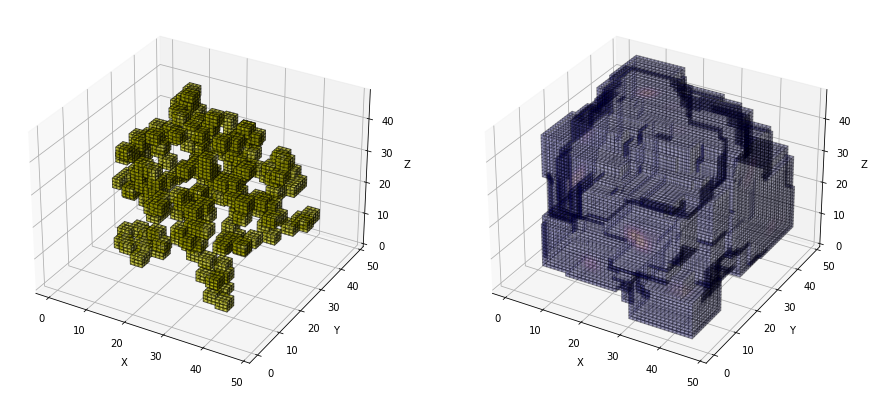

In [36]:
d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.voxels(d,facecolors='yellow', alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Creating a FC layer

Here we show an example of how we would create a Quantum fully-connected layer, that we can then use in our hybrid neural network.

### Example 1

In [37]:
# One example of observables to measure (measure <Z> for all the qubits)
input_size=4
obs = ["I"*input_size for n in range(input_size)]
for i in range(input_size):
    obs[i] = obs[i][:i] + 'Z' + obs[i][(i+1):]

In [38]:
# EInitializing the class
qnn= QuantumFCLayer(input_size=input_size, n_layers=1, encoding='qubit', ansatz=1, obs_name = obs, 
                    backend = 'aer_simulator_statevector')

# Create the quantum layer
qnn_layer = qnn.create_layer()

In [39]:
# Now you can use it as a normal FC layer. Let's calculate the output of a tensor
qnn_layer(torch.rand([2,input_size]))

tensor([[0.8832, 0.7692, 0.9702, 0.7820],
        [0.5666, 0.9768, 0.9240, 0.9465]], grad_fn=<_TorchNNFunctionBackward>)

### Example 2

In [40]:
# Another example with different parameters
nfeatures = 32
qnn= QuantumFCLayer(nfeatures, n_layers=2, encoding='amplitude', ansatz=2, obs_name = "Z"*10)

qnn_layer = qnn.create_layer()

Cannot compute gradient operator! Continuing without gradients!


In [41]:
qnn_layer(torch.rand([2,nfeatures]))

tensor([[0.0863, 0.0863, 0.0863, 0.0863, 0.0863, 0.0863, 0.0863, 0.0863, 0.0863,
         0.0863],
        [0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573, 0.0573,
         0.0573]], grad_fn=<_TorchNNFunctionBackward>)

## Create the hybrid quantum-classical neural network

Here we provide an example of how to create a hybrid neural network, using the quantum layer as a fully-connecte layer.

In [42]:
import os
import sys
import math
import numbers
import numpy as np
import scipy as sp
import torch
import torch.nn as nn


class Model_hybrid(nn.Module):

    def __init__(self, feat_dim=19, n_layers = 2, num_filters=[57,128,256], verbose=0, 
                encoding='qubit', ansatz=1, obs_name = "Z"*8, backend = "aer_simulator_statevector"):
        super(Model_hybrid, self).__init__()
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.verbose = verbose

        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.verbose = verbose

        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 2, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 3, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(2048, 10)
        self.relu = nn.ReLU()
        
        ##################################################################################################
        # Quantum part
        self.qnn_inst = QuantumFCLayer(10, n_layers, encoding, ansatz, obs_name, backend)
        self.qnn = self.qnn_inst.create_layer()
        ##################################################################################################
        
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if self.verbose != 0:
            print('Input', list(x.size()))
        
        conv1= self.conv1(x)
        if self.verbose != 0:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose != 0:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        pool1 = self.max_pool1(conv2)
        if self.verbose != 0:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose != 0:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose != 0:
            print('Pooling 2', list(pool2.shape))

        flatten = torch.flatten(pool2, start_dim=1)
        if self.verbose != 0:
            print('Flatten', list(flatten.shape))

        fc1 = self.fc1(flatten)
        fc1 = self.relu(fc1)
        if self.verbose != 0:
            print('Fc1', list(fc1.shape))
            
        # Quantum part
        quantum = self.qnn(fc1)
        if self.verbose != 0:
            print('Quantum', list(quantum.shape))
            
        fc2 = self.fc2(quantum)
        if self.verbose != 0:
            print('Fc2', list(fc2.shape))
            
        return fc2
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
input_size=10
obs = ["I"*input_size for n in range(input_size)]
for i in range(input_size):
    obs[i] = obs[i][:i] + 'Z' + obs[i][(i+1):]
    
model1 = Model_hybrid(verbose=1, obs_name=obs)

In [44]:
print('Number of parameters hybrid CNN: ', count_parameters(model1))

Number of parameters hybrid CNN:  6991841


In [45]:
# forward training
ypred_batch1 = model1(vol_batch[:x_batch.shape[0]])

Input [5, 19, 48, 48, 48]
Conv1 (7x7x7) [5, 57, 24, 24, 24]
Conv2 (7x7x7) [5, 128, 8, 8, 8]
Pooling 1 [5, 128, 4, 4, 4]
Conv 3 (7x7x7) [5, 256, 4, 4, 4]
Pooling 2 [5, 256, 2, 2, 2]
Flatten [5, 2048]
Fc1 [5, 10]
Quantum [5, 10]
Fc2 [5, 1]


## Training steps

Here we provide an example of how to train the model. Notice that the training process is the same as if we were training a neural network with pytorch. We train the model for 2 epochs as an example. We use Adam optimizer with learning rate 0.1.

In [ ]:
dataset = Dataset_MLHDF('../data/pdbbind2016_refined_val.hdf', 1, '../data/refined_val_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=100)
val_dataset = Dataset_MLHDF('../data/pdbbind2016_core_test.hdf', 1, '../data/core_test_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=100)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0, worker_init_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=1,vol_dim=48)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

# Training params
epoch_count=1 
start_time = time.time()

model1 = Model_hybrid(verbose=0, obs_name=obs)

# Define optimizer and loss function
optimizer1 = Adam(model1.parameters(), lr=0.1)
loss_func1 = MSELoss(reduction="sum")
batch_count = len(dataset) // 20

# Training loop
for epoch_ind in range(0, epoch_count):
    losses = []
    vol_batch = torch.zeros((20,19,48,48,48)).float()
    for batch_ind, batch in enumerate(dataloader):
        x_batch_cpu, y_batch_cpu = batch
        x_batch, y_batch = x_batch_cpu, y_batch_cpu
        # voxelize into 3d volume
        for i in range(x_batch.shape[0]):
            xyz, feat = x_batch[i, :, :3], x_batch[i, :, 3:]
            vol_batch[i, :, :, :, :] = voxelizer(xyz, feat)
        vol_batch = gaussian_filter(vol_batch)
        
        # forward training
        ypred_batch  = model1(vol_batch[:x_batch.shape[0]])
        loss = loss_func1(ypred_batch.cpu().float(), y_batch_cpu.float())
        losses.append(loss.cpu().data.item())
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        losses.append(loss.cpu().data.item())
        time_step = time.time() - start_time
        print("[%d/%d-%d/%d] training, loss: %.3f, time so far: %.3f seconds" % (epoch_ind+1, epoch_count,
                  batch_ind+1, batch_count, loss.cpu().data.item(), time_step))
        
    print("[%d/%d] training, epoch loss: %.3f, time so far: %.3f seconds\n" %
              (epoch_ind+1, epoch_count, np.mean(losses), time_step))
    
    val_losses = []
    for batch_ind, batch in enumerate(val_dataloader):
        x_batch_cpu, y_batch_cpu = batch
        x_batch, y_batch = x_batch_cpu, y_batch_cpu
        # voxelize into 3d volume
        for i in range(x_batch.shape[0]):
            xyz, feat = x_batch[i, :, :3], x_batch[i, :, 3:]
            vol_batch[i, :, :, :, :] = voxelizer(xyz, feat)
        vol_batch = gaussian_filter(vol_batch)
        ypred_batch = model1(vol_batch[:x_batch.shape[0]])
        loss = loss_func1(ypred_batch.cpu().float(),
                                       y_batch_cpu.float())
        print("[%d/%d-%d/%d] validation, loss: %.3f" % (epoch_ind+1,
                          epoch_count, batch_ind+1, batch_count, loss.cpu().data.item()))
        
        val_losses.append(loss.cpu().data.item())
        
    print("[%d/%d] validation, epoch loss: %.3f\n" %
                      (epoch_ind+1, epoch_count, np.mean(val_losses)))

# close dataset
dataset.close()
val_dataset.close()

[1/1-1/19] training, loss: 1.297, time so far: 3752.249 seconds


### Code to save the model

In [26]:
# save the model
torch.save(model1.state_dict(), "model1_fc.pt")


### Code to load the model

In [27]:
# create a new model
loaded_model = Model_hybrid(verbose=0)
loaded_model.load_state_dict(torch.load("model1_fc.pt"))

<All keys matched successfully>

## Available architectures for the Quantum Fully-connected layer

Here we describe the different implemented architectures for the quantum fully-connected layer, that the user can explore and play with. Such quantum layer contains two parts: a data encoding layer and a parametrized quantum circuit. 

## Data encoding

It is the process of encoding classical data into a quantum circuit. We propose different alternatives.

### 1. Qubit encoding

This is the default encoding. This encoding uses one qubit for each classical number that we want to encode. However, it ony uses one quantum gate for each qubit.

$$
|\phi(x)> = \otimes_{i=1}^N (\cos(\frac{x_i}{2} |0> + \sin(\frac{x_i}{2} |1>)
$$

Example:

In [46]:
nqbits = 4

qc_input = QuantumCircuit(nqbits)

# 1. Ry gates Initialization
thetas_ry_input = [qiskit.circuit.Parameter('thetas_input_' + str(i)) for i in range(nqbits)]#qiskit.circuit.ParameterVector('thetas_ry1', nqbits)  
for i in range(nqbits):
    qc_input.ry(thetas_ry_input[i], i)

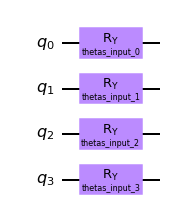

In [47]:
qc_input.draw('mpl')

### 2. Amplitude encoding

This encoding uses a $log_2(\text{features})$ qubits to encode the data, but it requires many more quantum gates.

$$
|\phi(x)> = \frac{1}{|x|} \sum_{i=1}^N x_i |i>
$$

Notice that this initialization can not be optimized with gradient-based optimizers.

In [48]:
nqbits = 4

# 1. Amplitude encoding initialization
qc_input2 = RawFeatureVector(2**nqbits)

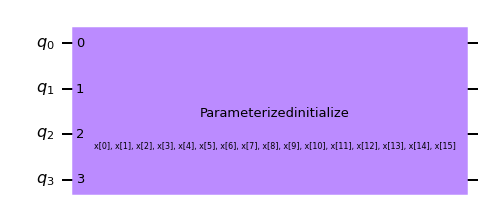

In [49]:
qc_input2.draw('mpl')

### 3. ZZFeatureMap

Second-order Pauli-Z evolution circuit.

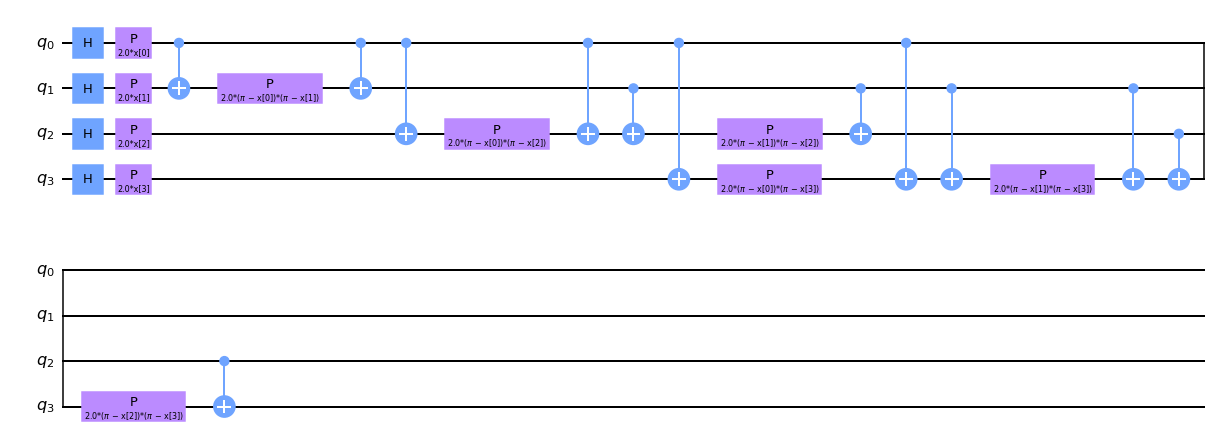

In [50]:
nqbits = 4
qc_input = ZZFeatureMap(nqbits, reps=1)

qc_input.decompose().draw('mpl')

## Ansatz

The second part of the circuit is a paramterized quantum circuit (PQC). The choice of this quantum circuit (ansatz) determines the performance of the model. In Ref. [1], the authors explore different choces of PQC and measure two quantum properties: the Expressability and the Entanglement capacity.

+ Expressibility measures a PQC’s ability to explore the Hilbert Space, that is, to produce different quantum states. To measure it, one calculates the probability distribution of the fidelity of two random states from the circuit. This distribution is then compared with the random distribution (Haar random states). The KL divergence of the two distributions is the Expressibility of the circuit. The value of Expressibility is less for more expressive circuits.

+ Entanglement Capability is a numerical method that quantifies a PQCs ability to produce entangled states. It averages the Meyer-Wallach entanglement measure (Q) over many random samples obtained from the PQC.

Expressibility and Entanglement Capability are descriptors that allow comparison of layered PQCs. For this reason, we provide circuits with different values of Expressibility and Entangling capacity. We provide six PQC, ordered in terms of performance and lower complexity based on Refs. [2],[3],[1]. 

[1] Sim, S., Johnson, P.D. and Aspuru-Guzik, A. (2019), Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum-Classical Algorithms. Adv. Quantum Technol., 2: 1900070. https://doi.org/10.1002/qute.201900070

[2] Tüysüz, C., Rieger, C., Novotny, K. et al. Hybrid quantum classical graph neural networks for particle track reconstruction. Quantum Mach. Intell. 3, 29 (2021). https://doi.org/10.1007/s42484-021-00055-9

[3] Hur, Tak & Kim, Leeseok & Park, Daniel. (2021). Quantum convolutional neural network for classical data classification. https://doi.org/10.1103/PhysRevResearch.4.013231


### 1. Circuit 10 

This circuit has low expressability. It provided the best performance for the NN in Ref. [2]. It's option 1 for the Quantum Layer.

In [51]:
nqbits = 4
qc_ansatz = QuantumCircuit(nqbits)    
# Choose the number of layers of the PQC
n_layers = 2
thetas_ry_weight = []
qbit_list = [(nqbits-1, nqbits-2)] + [(i,i-1) for i in range(nqbits-2,0,-1)] + [(nqbits-1,0)]
for layer in range(n_layers):
    # 2. Phase shifts
    for (qbit1, qbit2) in qbit_list:
        qc_ansatz.cz(qbit1, qbit2)
    qc_ansatz.barrier()

    # 3. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_weight += thetas_new
    for i in range(nqbits):
        qc_ansatz.ry(thetas_new[i], i)
    

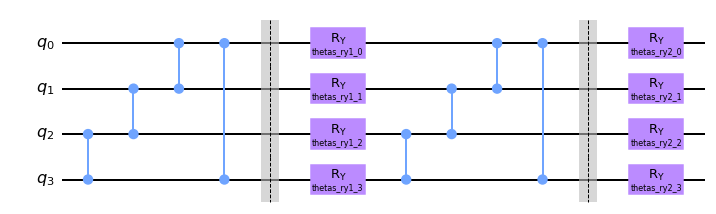

In [52]:
qc_ansatz.draw('mpl')

### Circuit 9
This circuit has the best Entangling capacity from the study in Ref. [1]. It's option 2 for the Quantum Layer.

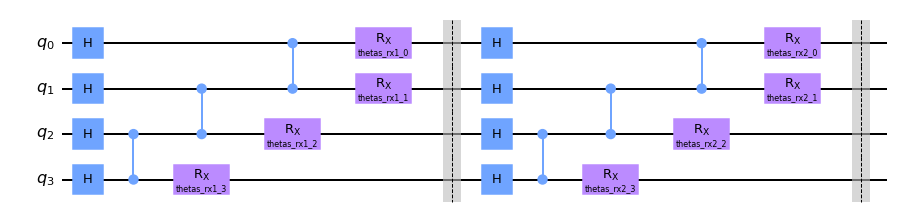

In [53]:
nqbits = 4
qc_ansatz = QuantumCircuit(nqbits)

n_layers = 2
thetas_rx_weight = []
qbit_list = [(i,i-1) for i in range(nqbits-1,0,-1)]
for layer in range(n_layers):
    # 1. Hadamard
    for q in range(nqbits):
        qc_ansatz.h(q)
    # 2. Phase shifts
    for (qbit1, qbit2) in qbit_list:
        qc_ansatz.cz(qbit1, qbit2)

    # 3. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_rx' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_rx_weight += thetas_new
    for i in range(nqbits):
        qc_ansatz.rx(thetas_new[i], i)
    qc_ansatz.barrier()
    
qc_ansatz.draw('mpl')    

### Circuit 15

This circuit has high entangling capacity and low expressability. It has lower complexiyt than circuits 14 and 13. It's option 3 for the Quantum Layer.

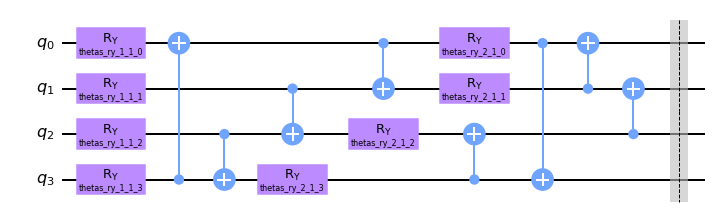

In [54]:
nqbits = 4
qc_ansatz = QuantumCircuit(nqbits)

n_layers = 1
thetas_ry_list = []
qbit_list = [(0, nqbits-1)] + [(i,i-1) for i in range(nqbits-1,0,-1)]
qbit_list2 = [(nqbits-2, nqbits-1), (nqbits-1,0)] + [(i,i+1) for i in range(0, nqbits-2)]
for layer in range(n_layers):
    # 1. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_1_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for q in range(nqbits):
        qc_ansatz.ry(thetas_new[q], q)
    # 2. CNOTS
    for (qbit1, qbit2) in qbit_list:
        qc_ansatz.cx(qbit2, qbit1)
    # 3. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_2_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for i in range(nqbits):
        qc_ansatz.ry(thetas_new[i], i)
    # 4. CNOTS
    for (qbit1, qbit2) in qbit_list2:
        qc_ansatz.cx(qbit2, qbit1)
    qc_ansatz.barrier()
    
qc_ansatz.draw('mpl')    

### Circuit 14

This circuit balanced significance in entangling capacity and expressability. It has higher complexiy than circuit 15. It's option 4 for the Quantum Layer.

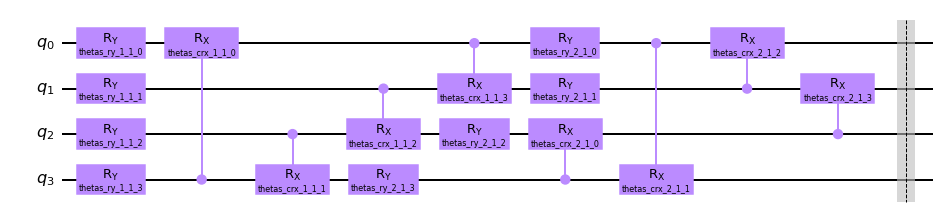

In [55]:
nqbits = 4
n_layers = 1

qc_ansatz = QuantumCircuit(nqbits)
thetas_ry_list = []
thetas_crx_list = []
qbit_list = [(0, nqbits-1)] + [(i,i-1) for i in range(nqbits-1,0,-1)]
qbit_list2 = [(nqbits-2, nqbits-1), (nqbits-1,0)] + [(i,i+1) for i in range(0, nqbits-2)]
for layer in range(n_layers):
    # 1. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_1_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for q in range(nqbits):
        qc_ansatz.ry(thetas_new[q], q)
    # 2. Controlled Rx
    thetas_new = [qiskit.circuit.Parameter('thetas_crx_1_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_crx_list+=thetas_new
    i=0
    for (qbit1, qbit2) in qbit_list:
        qc_ansatz.crx(thetas_new[i],qbit2, qbit1)
        i+=1
    # 3. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_2_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for i in range(nqbits):
        qc_ansatz.ry(thetas_new[i], i)
    # 4. Controlled Rx
    thetas_new = [qiskit.circuit.Parameter('thetas_crx_2_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_crx_list+=thetas_new
    i=0
    for (qbit1, qbit2) in qbit_list2:
        qc_ansatz.crx(thetas_new[i],qbit2, qbit1)
        i+=1
    qc_ansatz.barrier()
    
qc_ansatz.draw('mpl')    

### Circuit 13

This circuit balanced significance in entangling capacity and expressability. It has higher complexiy than circuit 15. It's option 5 for the Quantum Layer.

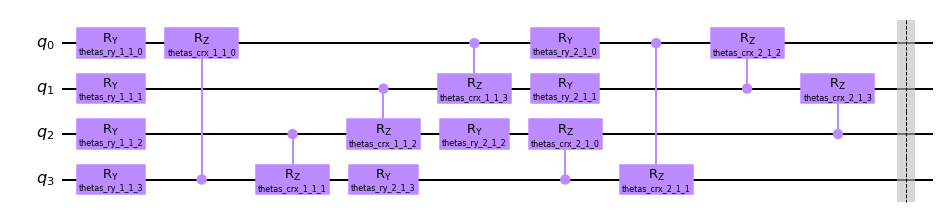

In [56]:
nqbits = 4
n_layers = 1

qc_ansatz = QuantumCircuit(nqbits)
thetas_ry_list = []
thetas_crz_list = []
qbit_list = [(0, nqbits-1)] + [(i,i-1) for i in range(nqbits-1,0,-1)]
qbit_list2 = [(nqbits-2, nqbits-1), (nqbits-1,0)] + [(i,i+1) for i in range(0, nqbits-2)]
for layer in range(n_layers):
    # 1. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_1_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for q in range(nqbits):
        qc_ansatz.ry(thetas_new[q], q)
    # 2. Controlled Rx
    thetas_new = [qiskit.circuit.Parameter('thetas_crx_1_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_crz_list+=thetas_new
    i=0
    for (qbit1, qbit2) in qbit_list:
        qc_ansatz.crz(thetas_new[i],qbit2, qbit1)
        i+=1
    # 3. Ry gates
    thetas_new = [qiskit.circuit.Parameter('thetas_ry_2_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_ry_list += thetas_new
    for i in range(nqbits):
        qc_ansatz.ry(thetas_new[i], i)
    # 4. Controlled Rx
    thetas_new = [qiskit.circuit.Parameter('thetas_crx_2_' + str(layer+1)+'_'+str(i))  for i in range(nqbits)]
    thetas_crz_list+=thetas_new
    i=0
    for (qbit1, qbit2) in qbit_list2:
        qc_ansatz.crz(thetas_new[i],qbit2, qbit1)
        i+=1
    qc_ansatz.barrier()
    
qc_ansatz.draw('mpl')    

### 2. Circuit 6

This circuit has the highest expressability, but very high complexity. It's option 6 for the Quantum Layer.

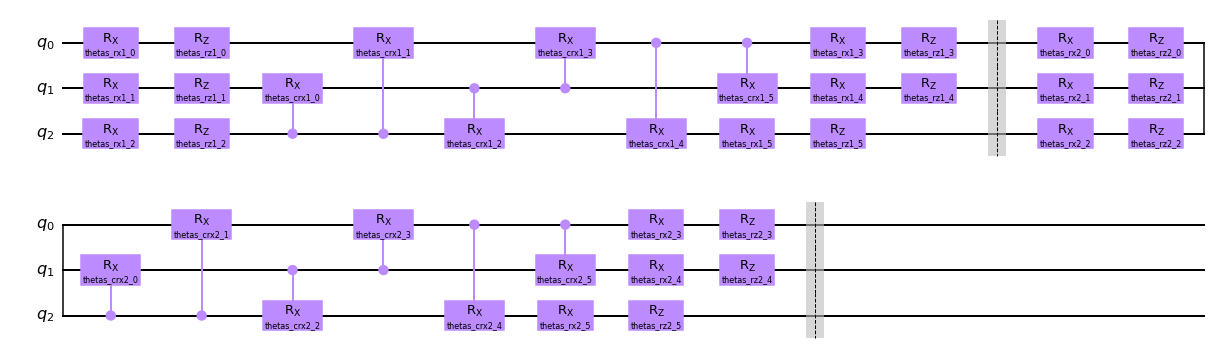

In [57]:
nqbits = 3
qc_ansatz = QuantumCircuit(nqbits)    

n_layers = 2
thetas_rx_list = []
thetas_rz_list = []
thetas_crx_list = []
for layer in range(n_layers):    
    thetas_rx = [Parameter('thetas_rx' +str(layer+1)+ '_'+str(i))  for i in range(2*nqbits)]
    thetas_rz = [Parameter('thetas_rz' + str(layer+1)+'_'+str(i))  for i in range(2*nqbits)]
    thetas_crx = [Parameter('thetas_crx' +str(layer+1)+ '_'+str(i))  for i in range((nqbits-1)*nqbits)]
    thetas_rx_list+=thetas_rx
    thetas_rz_list+=thetas_rz
    thetas_crx_list+=thetas_crx
    
    # First Rx layer
    for i in range(nqbits):
        qc_ansatz.rx(thetas_rx[i],i)

    # First Ry layer
    for i in range(nqbits):
        qc_ansatz.rz(thetas_rz[i],i)

    # Controlled Rx
    l=0
    for i in range(nqbits-1,-1,-1): # i= controlled qubits
        qubits = list(range(nqbits-1,-1,-1))
        qubits.remove(i)
        for q in qubits:
            qc_ansatz.crx(thetas_crx[l], i,q)
            l+=1

    # Second Rx layer
    for i in range(nqbits):
        qc_ansatz.rx(thetas_rx[i+nqbits],i)

    # Second Ry layer
    for i in range(nqbits):
        qc_ansatz.rz(thetas_rz[i+nqbits],i)
        
    qc_ansatz.barrier() 
    
qc_ansatz.draw('mpl')